# Modelo para previsão dos casos (surtos) de dengue em São Paulo

## Obtenção e preparação dos dados

### Função com criação dinâmica dos dfs por ano

In [10]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from pathlib import Path
import geobr 
from pysus import SINAN 
import os
def preparar_dataset_dengue_clima(
    path_inmet_zip: str, 
    path_ibge_csv: str,
    path_dengue_parquet: str = None, 
    ano_referencia: int = 2021
):
    print(f"\n>>> Processando Ano {ano_referencia} com Tratamento de Gaps <<<")
    

    # DENGUE (pysus)
    print("Carregando dados de Dengue...")
    df_dengue = None
    
    if path_dengue_parquet:
        try:
            df_dengue = pd.read_parquet(path_dengue_parquet)
        except FileNotFoundError:
            pass
            
    if df_dengue is None:
        try:
            p_home = Path.home() / "pysus" / f"DENGBR{str(ano_referencia)[-2:]}.parquet"
            if p_home.exists():
                df_dengue = pd.read_parquet(p_home)
        except:
            pass
            
    if df_dengue is None:
        print("Arquivo local não encontrado. Baixando via PySUS...")
        try:
            sinan = SINAN().load()
            files = sinan.get_files(dis_code=["DENG"], year=ano_referencia)
            df_dengue = sinan.download(files) 
        except Exception as e:
            print(f"   Erro fatal ao baixar Dengue: {e}")
            return None

    # Filtros
    df_dengue = df_dengue[df_dengue["CLASSI_FIN"].astype(str).str.strip() != "5"]
    df_dengue_agg = df_dengue.groupby(["DT_NOTIFIC", "ID_MUNICIP"]).size().reset_index(name="casos_dengue")
    df_dengue_agg["ID_MUNICIP"] = df_dengue_agg["ID_MUNICIP"].astype(int)
    


    # INMET
    print("Processando dados do INMET...")
    try:
        from reader_inmet import read_zipfile
        df_inmet = read_zipfile(path_inmet_zip)
    except ImportError:
        df_inmet = pd.read_csv(path_inmet_zip) 
        
    df_inmet['data_hora'] = pd.to_datetime(df_inmet['data_hora'])
    df_inmet['data_date'] = df_inmet['data_hora'].dt.date
    
    # Agregação Diária Inicial
    aggs = {
        'precipitacao': 'sum',
        'temperatura_maxima': 'max',
        'temperatura_minima': 'min',
        'temperatura_ar': 'mean',
        'umidade_relativa': 'mean',
        'vento_velocidade': 'mean',
        'latitude': 'first',
        'longitude': 'first'
    }
    cols_existentes = [c for c in aggs.keys() if c in df_inmet.columns]
    aggs_finais = {k: v for k, v in aggs.items() if k in cols_existentes}

    # Agrupa por Estação e Data
    df_inmet_diario = df_inmet.groupby(['codigo_wmo', 'data_date']).agg(aggs_finais).reset_index()

    print("Aplicando preenchimento de falhas nas estações (Gap Filling)...")

    # Cria um intervalo de datas completo para o ano
    all_dates = pd.date_range(start=f'{ano_referencia}-01-01', end=f'{ano_referencia}-12-31', freq='D').date
    
    lista_dfs_curados = []
    
    # Processa cada estação individualmente
    for estacao, dados in df_inmet_diario.groupby('codigo_wmo'):
        # Reindexa para garantir que todos os dias existam (cria NaNs nos dias faltantes)
        dados = dados.set_index('data_date').reindex(all_dates)
        
        # Preenche metadados (lat/lon/codigo) que ficaram NaN na reindexação
        dados['codigo_wmo'] = estacao
        # Lat/Lon são constantes da estação, aqui pode usar bfill/ffill sem risco de vazamento temporal grave
        dados['latitude'] = dados['latitude'].ffill().bfill()
        dados['longitude'] = dados['longitude'].ffill().bfill()
        
        cols_numericas = [c for c in cols_existentes if c not in ['latitude', 'longitude']]

        dados[cols_numericas] = dados[cols_numericas].ffill(limit=5) 
        
        dados.index.name = 'data_date'
        lista_dfs_curados.append(dados.reset_index())
    
    # Reconstrói o DF tratado
    df_inmet_full = pd.concat(lista_dfs_curados)
    df_inmet_full['DT_NOTIFIC'] = pd.to_datetime(df_inmet_full['data_date']).dt.strftime('%Y%m%d')



    # IBGE (geobr)
    print("Processando dados do IBGE...")
    try:
        df_geo = geobr.read_municipal_seat(year=2010)
        df_geo['id_municip_6'] = (df_geo['code_muni'] // 10).astype(int)
        
        geo_col = 'geometry' if 'geometry' in df_geo.columns else 'geom'
        df_geo['lat_mun'] = df_geo[geo_col].apply(lambda x: x.y)
        df_geo['lon_mun'] = df_geo[geo_col].apply(lambda x: x.x)
    except Exception as e:
        print(f"Erro no geobr: {e}")
        return None


    # KDTree - Usando apenas estações que sobraram no df_inmet_full (algumas podem ter sumido se vazias)
    estacoes_validas = df_inmet_full[['codigo_wmo', 'latitude', 'longitude']].drop_duplicates().dropna()
    municipios_validos = df_geo[['id_municip_6', 'name_muni', 'lat_mun', 'lon_mun']].drop_duplicates().dropna(subset=['lat_mun', 'lon_mun'])
    
    tree = cKDTree(estacoes_validas[['latitude', 'longitude']].values)
    distancias, indices = tree.query(municipios_validos[['lat_mun', 'lon_mun']].values, k=1)
    
    municipios_validos['estacao_proxima'] = estacoes_validas.iloc[indices]['codigo_wmo'].values
    mapa_estacoes = municipios_validos[['id_municip_6', 'name_muni', 'estacao_proxima']]



    # JOIN FINAL
    print("4. Unificando datasets...")
    
    df_final = pd.merge(df_dengue_agg, mapa_estacoes, left_on='ID_MUNICIP', right_on='id_municip_6', how='left')
    
    # Merge com o INMET curado
    df_final = pd.merge(
        df_final, 
        df_inmet_full, 
        left_on=['estacao_proxima', 'DT_NOTIFIC'], 
        right_on=['codigo_wmo', 'DT_NOTIFIC'], 
        how='left'
    )
    
    if 'id_municip_6' in df_final.columns:
        df_final.drop(columns=['id_municip_6'], inplace=True)
    if 'data_date' in df_final.columns:
        df_final.drop(columns=['data_date'], inplace=True)
        
    print(f"   Shape final: {df_final.shape}")
    print(f"   Linhas com NaN na temp média: {df_final['temperatura_ar'].isna().sum()}")
    df_final = df_final.sort_values('DT_NOTIFIC')
    return df_final

### Criação do df final de 2020 até 2023

In [11]:
years_to_process = [2020, 2021, 2022, 2023]
ibge_path = "data/RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.csv"
dfs_result = []

for year in years_to_process:
    inmet_path = f"data/{year}.zip"
    
    # Verifica se arquivos existem antes de chamar (para evitar logs de erro desnecessários)
    if os.path.exists(inmet_path):
        try:
            df_year = preparar_dataset_dengue_clima(
                path_inmet_zip=inmet_path,
                path_ibge_csv=ibge_path,
                ano_referencia=year
            )
            if df_year is not None and not df_year.empty:
                dfs_result.append(df_year)
                print(f"   > Sucesso: {len(df_year)} registros para {year}")
            else:
                print(f"   > Aviso: Nenhum dado gerado para {year}")
        except Exception as e:
            print(f"   > Falha ao processar {year}: {e}")
    else:
        print(f"   > Arquivo INMET não encontrado para {year} ({inmet_path}), pulando.")

# Concatenação e Salvamento
df_merged = pd.concat(dfs_result, ignore_index=True)
df_merged.sort_values("DT_NOTIFIC", inplace=True)

output_filename = "dengue_clima_2020_2024.csv"
df_merged.to_csv(output_filename, index=False)

print("\n" + "="*30)
print(f"CONSOLIDADO FINAL (2020-2024)")
print(f"Arquivo salvo: {output_filename}")
print(f"Total de registros: {len(df_merged)}")
print("Colunas:", list(df_merged.columns))
print(df_merged.head())


>>> Processando Ano 2020 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 589/589 [00:44<00:00, 13.12it/s]


Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (173242, 14)
   Linhas com NaN na temp média: 14926
   > Sucesso: 173242 registros para 2020

>>> Processando Ano 2021 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 588/588 [00:32<00:00, 18.08it/s]


Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (112129, 14)
   Linhas com NaN na temp média: 24864
   > Sucesso: 112129 registros para 2021

>>> Processando Ano 2022 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 567/567 [00:39<00:00, 14.47it/s]


Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (214659, 14)
   Linhas com NaN na temp média: 41858
   > Sucesso: 214659 registros para 2022

>>> Processando Ano 2023 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 567/567 [00:50<00:00, 11.24it/s]


Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (213841, 14)
   Linhas com NaN na temp média: 17734
   > Sucesso: 213841 registros para 2023

CONSOLIDADO FINAL (2020-2024)
Arquivo salvo: dengue_clima_2020_2024.csv
Total de registros: 713871
Colunas: ['DT_NOTIFIC', 'ID_MUNICIP', 'casos_dengue', 'name_muni', 'estacao_proxima', 'codigo_wmo', 'precipitacao', 'temperatura_maxima', 'temperatura_minima', 'temperatura_ar', 'umidade_relativa', 'vento_velocidade', 'latitude', 'longitude']
    DT_NOTIFIC  ID_MUNICIP  casos_dengue                 name_muni  \
0     20191229      110014             1  Nova Brasilândia D'oeste   
124   20191229      110037             1   Alto Alegre Dos Parecis   
125   20191229      120001             1                Acrelândia   
126   20191229      120020            10           Cruzeiro Do Sul   
127   20191229      120070             2                    Xapuri   

    es

### Filtrando apenas São Paulo e mostrando como ficou o df

In [12]:
df_sp = df_merged[df_merged['name_muni'] == 'São Paulo']
df_sp

,DT_NOTIFIC,ID_MUNICIP,casos_dengue,name_muni,estacao_proxima,codigo_wmo,precipitacao,temperatura_maxima,temperatura_minima,temperatura_ar,umidade_relativa,vento_velocidade,latitude,longitude
38,20191229,355030,3,São Paulo,A701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,20191230,355030,9,São Paulo,A701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,20191231,355030,2,São Paulo,A701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
813,20200101,355030,1,São Paulo,A701,A701,16.0,33.3,19.2,25.491667,60.791667,1.929167,-23.496294,-46.620088
1043,20200102,355030,9,São Paulo,A701,A701,23.6,28.8,20.0,22.625000,76.583333,1.291667,-23.496294,-46.620088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711253,20231226,355030,93,São Paulo,A701,A701,1.0,29.3,20.6,25.283333,63.208333,1.862500,-23.496389,-46.620000
711798,20231227,355030,83,São Paulo,A701,A701,0.0,27.2,18.1,21.495652,60.260870,2.486957,-23.496389,-46.620000
712378,20231228,355030,66,São Paulo,A701,A701,0.0,32.3,17.3,22.962500,58.333333,2.187500,-23.496389,-46.620000
712971,20231229,355030,58,São Paulo,A701,A701,0.0,34.7,19.6,26.833333,51.916667,1.970833,-23.496389,-46.620000


## Exploração dos dados e ajustes finais no df

count    1351.000000
mean       29.560326
std        49.245213
min         1.000000
25%         4.000000
50%        11.000000
75%        29.000000
max       358.000000
Name: casos_dengue, dtype: float64

Skewness (Assimetria): 3.01
Kurtosis (Curtose): 10.22


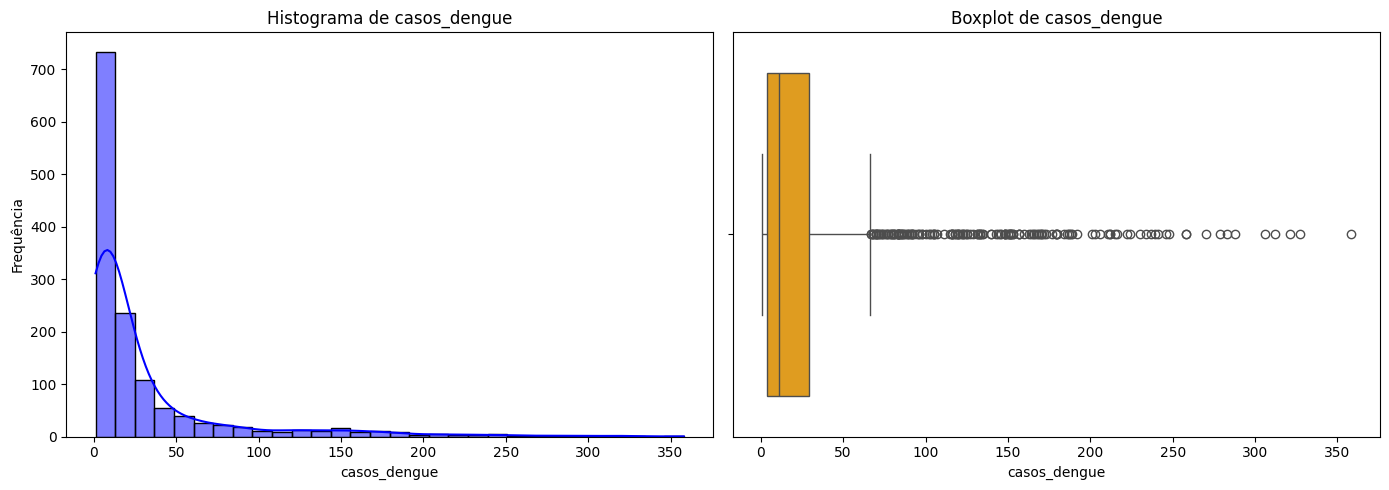

count    1348.000000
mean        4.206083
std        10.109749
min         0.000000
25%         0.000000
50%         0.000000
75%         2.600000
max       143.000000
Name: precipitacao, dtype: float64

Skewness (Assimetria): 4.41
Kurtosis (Curtose): 33.74


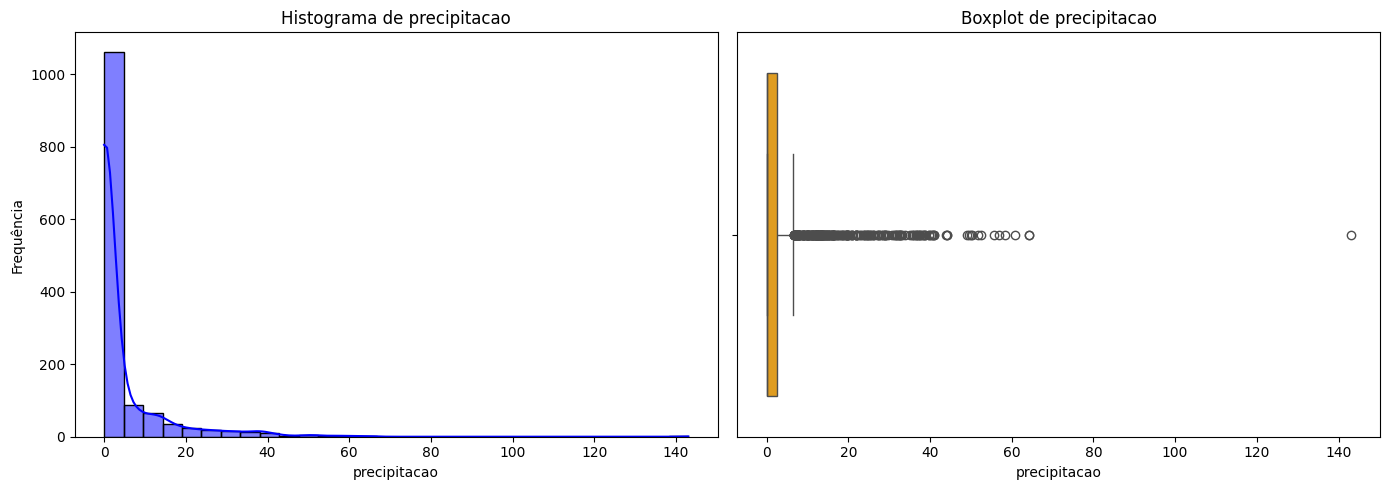

count    1348.000000
mean       20.469162
std         3.257299
min         7.947826
25%        18.293750
50%        20.604167
75%        22.877083
max        30.987500
Name: temperatura_ar, dtype: float64

Skewness (Assimetria): -0.24
Kurtosis (Curtose): 0.06


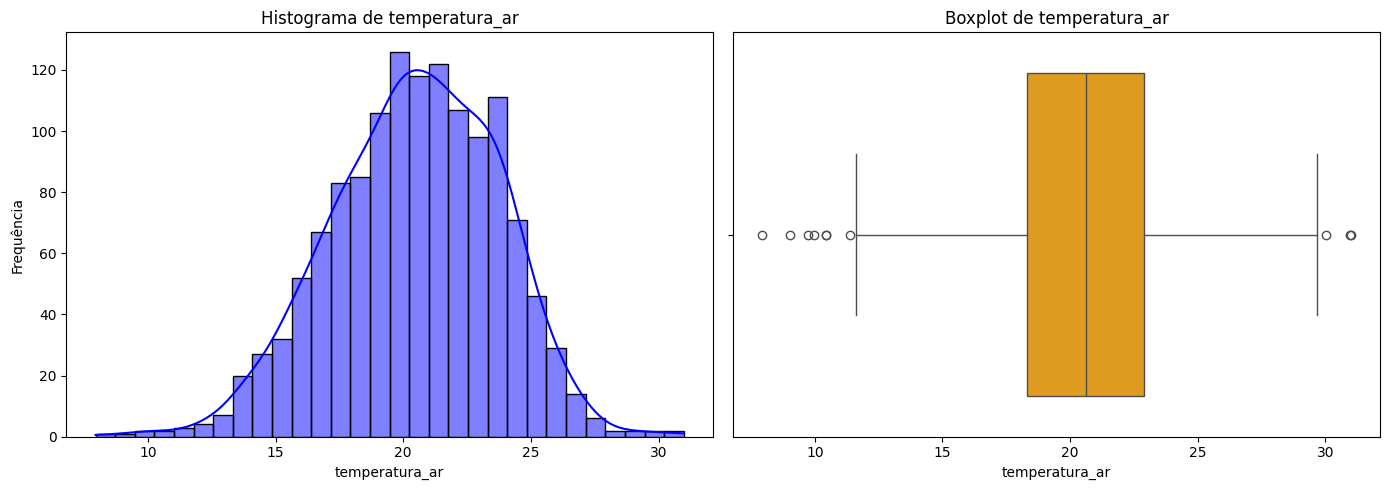

count    1348.000000
mean       68.613179
std        10.469959
min        28.523810
25%        63.333333
50%        69.625000
75%        75.625000
max        93.500000
Name: umidade_relativa, dtype: float64

Skewness (Assimetria): -0.63
Kurtosis (Curtose): 0.61


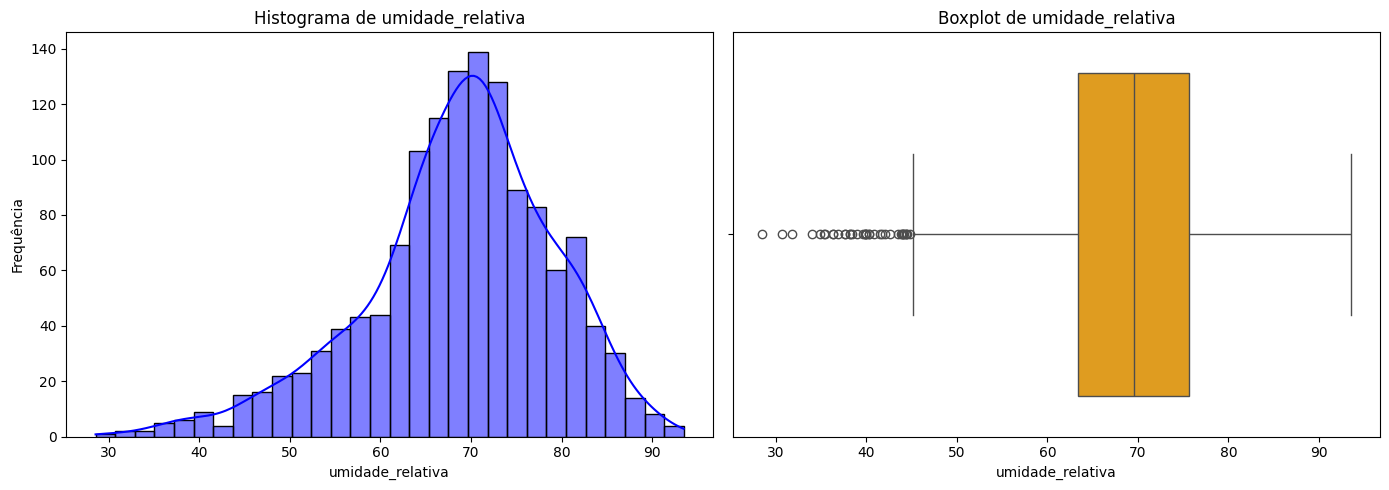

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def analisar_distribuicao(df, coluna='casos_dengue'):
    """
    Gera gráficos de distribuição e estatísticas para uma coluna específica.
    """
    
    # Estatísticas Descritivas
    desc = df[coluna].describe()
    print(desc)
    print(f"\nSkewness (Assimetria): {df[coluna].skew():.2f}")
    print(f"Kurtosis (Curtose): {df[coluna].kurtosis():.2f}")
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[coluna], kde=True, bins=30, color='blue')
    plt.title(f'Histograma de {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Frequência')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[coluna], color='orange')
    plt.title(f'Boxplot de {coluna}')
    plt.xlabel(coluna)
    
    plt.tight_layout()
    plt.show()

analisar_distribuicao(df_sp, 'casos_dengue')

cols_interesse = ['precipitacao', 'temperatura_ar', 'umidade_relativa']
for col in cols_interesse:
    if col in df_sp.columns:
        analisar_distribuicao(df_sp, col)

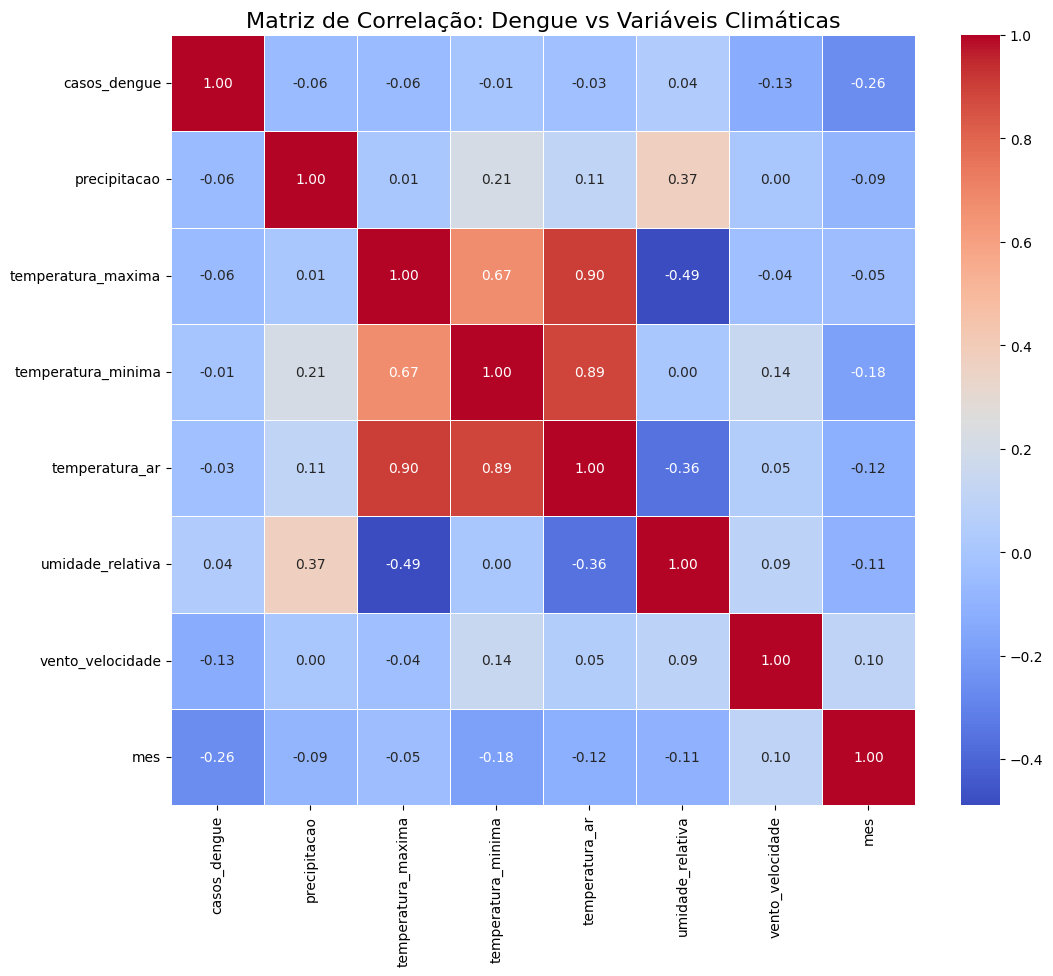

Colunas prontas para ML: ['casos_dengue', 'precipitacao', 'temperatura_maxima', 'temperatura_minima', 'temperatura_ar', 'umidade_relativa', 'vento_velocidade', 'mes']


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analisar_correlacao_ml(df):

    cols_ml = [
        'DT_NOTIFIC',
        'casos_dengue', 
        'precipitacao', 
        'temperatura_maxima', 
        'temperatura_minima', 
        'temperatura_ar', 
        'umidade_relativa', 
        'vento_velocidade'
    ]
    
    df_ml = df[cols_ml].copy()
    

    df_ml['DT_NOTIFIC'] = pd.to_datetime(df_ml['DT_NOTIFIC'])
    df_ml['mes'] = df_ml['DT_NOTIFIC'].dt.month
    
    df_ml = df_ml.drop(columns=['DT_NOTIFIC'])
    
    corr_matrix = df_ml.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=0.5
    )
    plt.title("Matriz de Correlação: Dengue vs Variáveis Climáticas", fontsize=16)
    plt.show()
    
    return df_ml

df_para_modelo = analisar_correlacao_ml(df_sp)

print("Colunas prontas para ML:", df_para_modelo.columns.tolist())

## Modelos de previsão

### XGBoost

>>> Preparando modelo (XGBoost - Split 70/10/20)...
MAE Final: 13.60


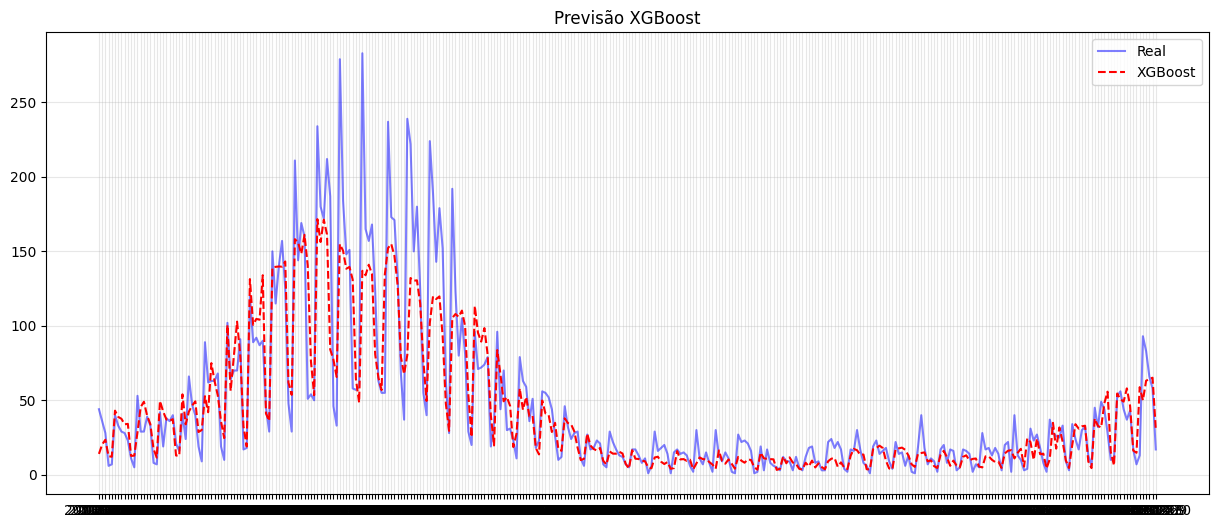

,objective,'count:poisson'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [15]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
def treinar_xgboost_dengue(df):
    print(">>> Preparando modelo (XGBoost - Split 70/10/20)...")
    
    if 'DT_NOTIFIC' in df.columns:
        df = df.sort_values('DT_NOTIFIC').copy()
    else:
        df = df.copy()
    
    cols_clima = ['precipitacao', 'temperatura_ar', 'umidade_relativa']
    for col in cols_clima:
        if col in df.columns:
            df[f'{col}_media_30d'] = df[col].rolling(30).mean()
    
    df['casos_lag_7d'] = df['casos_dengue'].shift(7)
    df['casos_lag_14d'] = df['casos_dengue'].shift(14)
    df['casos_media_movel_7d'] = df['casos_dengue'].rolling(7).mean().shift(1)

    df_model = df.dropna().copy()

    if 'mes' not in df_model.columns and 'DT_NOTIFIC' in df_model.columns:
        dates = pd.to_datetime(df_model['DT_NOTIFIC'])
        df_model['mes'] = dates.dt.month
        df_model['semana_do_ano'] = dates.dt.isocalendar().week.astype(int)

    features = [
        'mes', 'semana_do_ano',
        'precipitacao_media_30d', 'temperatura_ar_media_30d',
        'casos_lag_7d', 'casos_lag_14d', 'casos_media_movel_7d'
    ]
    features = [c for c in features if c in df_model.columns]

    X = df_model[features]
    y = df_model['casos_dengue']
    
    n = len(df_model)
    split_val = int(n * 0.50)       # Fim do Treino
    split_test = int(n * 0.75)      # Fim da Validação (70% + 10%)

    # 1. Treino (0-70%)
    X_train = X.iloc[:split_val]
    y_train = y.iloc[:split_val]

    # 2. Validação (70-80%)
    X_val = X.iloc[split_val:split_test]
    y_val = y.iloc[split_val:split_test]

    # 3. Teste (80-100%)
    X_test = X.iloc[split_test:]
    y_test = y.iloc[split_test:]
    
    model = xgb.XGBRegressor(
        objective='count:poisson',
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"MAE Final: {mae:.2f}")

    if 'DT_NOTIFIC' in df_model.columns:
        dates_test = df_model['DT_NOTIFIC'].iloc[split_test:]
        plt.figure(figsize=(15, 6))
        plt.plot(dates_test, y_test, label='Real', color='blue', alpha=0.5)
        plt.plot(dates_test, preds, label='XGBoost', color='red', linestyle='--')
        plt.title('Previsão XGBoost')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return model

treinar_xgboost_dengue(df_sp)

### LSTM

>>> Preparando dados para LSTM...
   Treino: 644 | Validação: 337 | Teste: 337
>>> Treinando...
Epoch 1/50


/home/Nishimura/anaconda3/envs/dengue_ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0197 - val_loss: 0.0350
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0096 - val_loss: 0.0301
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0286
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - val_loss: 0.0269
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 0.0275
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - val_loss: 0.0253
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0244
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - val_loss: 0.0246
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064 - val_loss: 0.0247
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0237
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - val_loss: 0.0253
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_l

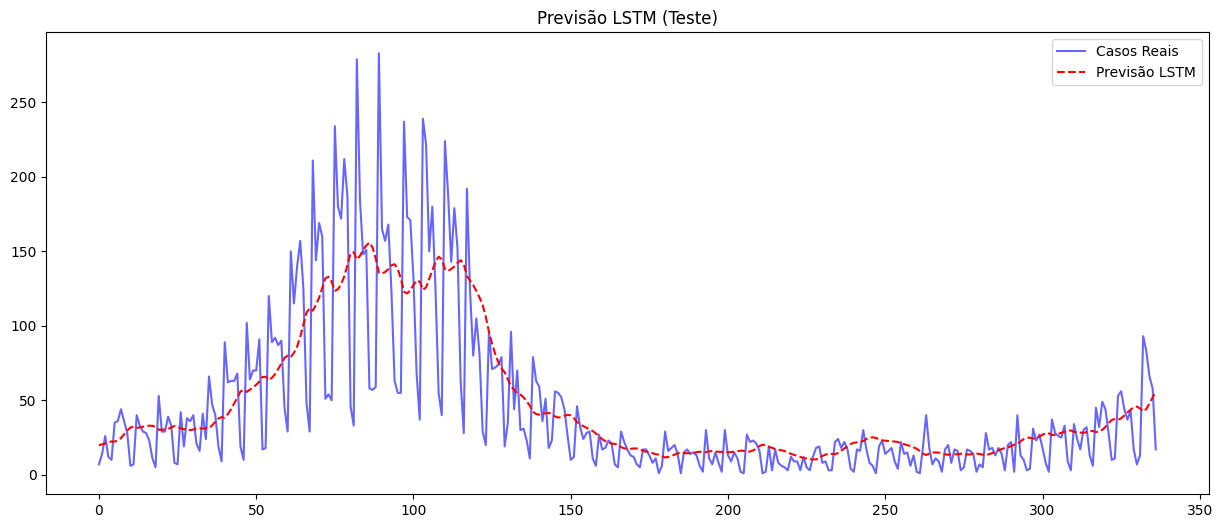

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def criar_sequencias(dados, janela_tempo):

    X, y = [], []
    for i in range(len(dados) - janela_tempo):
        X.append(dados[i:(i + janela_tempo), :])
        y.append(dados[i + janela_tempo, 0])
    return np.array(X), np.array(y)


def treinar_lstm_dengue(df, janela=30):
    print(">>> Preparando dados para LSTM...")
    
    if 'DT_NOTIFIC' in df.columns:
        df = df.sort_values('DT_NOTIFIC')
    
    features = ['casos_dengue', 'precipitacao', 'temperatura_ar', 'umidade_relativa']
    features = [c for c in features if c in df.columns]
    
    df_clean = df[features].dropna()
    data = df_clean.values
    n = len(data)
    
    split_val = int(n * 0.50)
    split_test = int(n * 0.75)
    
    train_raw = data[:split_val]
    val_raw = data[split_val - janela : split_test]
    test_raw = data[split_test - janela :]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit
    train_scaled = scaler.fit_transform(train_raw)
    
    # Transform na validação e teste (usando estatísticas do treino)
    val_scaled = scaler.transform(val_raw)
    test_scaled = scaler.transform(test_raw)
    
    # Criar sequências
    X_train, y_train = criar_sequencias(train_scaled, janela)
    X_val, y_val = criar_sequencias(val_scaled, janela)
    X_test, y_test = criar_sequencias(test_scaled, janela)
    
    print(f"   Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]} | Teste: {X_test.shape[0]}")
    
    # Modelo
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Callback para parar se não melhorar na validação
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    print(">>> Treinando...")
    history = model.fit(
        X_train, y_train,
        epochs=50,   
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=1
    )
    
    # Previsão no TESTE
    preds_scaled = model.predict(X_test)

    # Inversão da escala
    dummy_test = np.zeros((len(preds_scaled), len(features)))
    dummy_test[:, 0] = preds_scaled.flatten()
    preds_real = scaler.inverse_transform(dummy_test)[:, 0]
    preds_real = np.maximum(preds_real, 0)

    dummy_y = np.zeros((len(y_test), len(features)))
    dummy_y[:, 0] = y_test
    y_real = scaler.inverse_transform(dummy_y)[:, 0]
    
    mae = mean_absolute_error(y_real, preds_real)
    print(f"\n>>> MAE (Teste): {mae:.2f}")
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(y_real, label='Casos Reais', color='blue', alpha=0.6)
    plt.plot(preds_real, label='Previsão LSTM', color='red', linestyle='--')
    plt.title(f'Previsão LSTM (Teste)')
    plt.legend()
    plt.show()
    
    return model

model_lstm = treinar_lstm_dengue(df_sp, janela=30)

### Prophet

>>> Treinando com bandas de incerteza...


/tmp/ipykernel_27659/3197130472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['precipitacao'] = df_sp['precipitacao'].ffill().fillna(0)
/tmp/ipykernel_27659/3197130472.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['temperatura_ar'] = df_sp['temperatura_ar'].ffill()
/tmp/ipykernel_27659/3197130472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

>>> MAE Prophet: 28.79


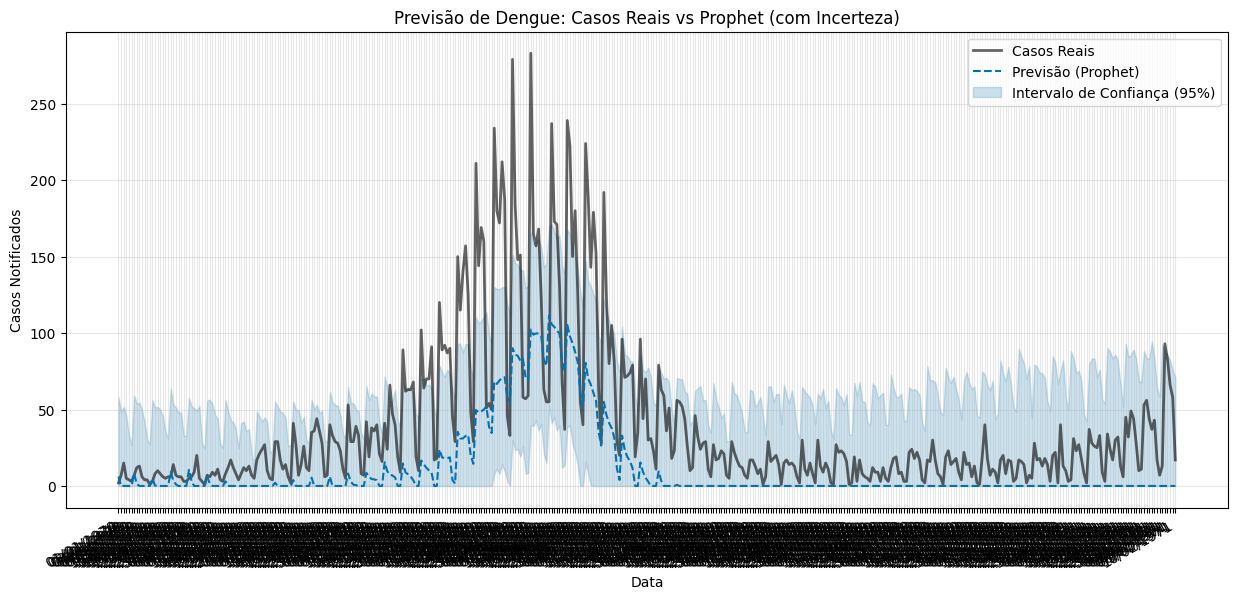


Exemplo da previsão:
            ds       yhat  yhat_lower  yhat_upper
401 2023-12-26 -54.272190 -191.392670   88.257376
402 2023-12-27 -60.760064 -199.720660   85.663422
403 2023-12-28 -62.082016 -200.220945   82.149614
404 2023-12-29 -62.445404 -206.657440   75.598340
405 2023-12-30 -80.849079 -224.695387   70.858773


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
from prophet import Prophet


# Use ffill para propagar dados do passado para o futuro apenas
df_sp['precipitacao'] = df_sp['precipitacao'].ffill().fillna(0)
df_sp['temperatura_ar'] = df_sp['temperatura_ar'].ffill()
df_sp['umidade_relativa'] = df_sp['umidade_relativa'].ffill()

# Se ainda sobrarem NaNs no início (onde não tem passado)
df_sp = df_sp.fillna(0)

# Preparação para o Prophet
df_prophet = df_sp[['DT_NOTIFIC', 'casos_dengue', 'precipitacao', 'temperatura_ar', 'umidade_relativa']].copy()
df_prophet = df_prophet.rename(columns={'DT_NOTIFIC': 'ds', 'casos_dengue': 'y'})
df_prophet = df_prophet.sort_values('ds')

# Divisão Treino/Teste
split_idx = int(len(df_prophet) * 0.7)
df_train = df_prophet.iloc[:split_idx]
df_test = df_prophet.iloc[split_idx:]

# Configuração e Treino
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95  # Define o intervalo de confiança em 95%
)

model.add_regressor('precipitacao')
model.add_regressor('temperatura_ar')
model.add_regressor('umidade_relativa')

print(">>> Treinando com bandas de incerteza...")
model.fit(df_train)

# Previsão
future = df_test[['ds', 'precipitacao', 'temperatura_ar', 'umidade_relativa']]
forecast = model.predict(future)

# Processamento dos Resultados
# Garantir que não haja valores negativos (comum em séries de contagem)
y_pred = np.maximum(forecast['yhat'].values, 0)
y_lower = np.maximum(forecast['yhat_lower'].values, 0)
y_upper = np.maximum(forecast['yhat_upper'].values, 0)
y_true = df_test['y'].values

mae = mean_absolute_error(y_true, y_pred)
print(f">>> MAE Prophet: {mae:.2f}")

plt.figure(figsize=(15, 7))

# Dados Reais
plt.plot(df_test['ds'], y_true, label='Casos Reais', color='black', alpha=0.6, linewidth=2)

# Previsão (Linha central)
plt.plot(df_test['ds'], y_pred, label='Previsão (Prophet)', color='#0072B2', linestyle='--')

# Bandas de Confiança
plt.fill_between(
    df_test['ds'], 
    y_lower, 
    y_upper, 
    color='#0072B2', 
    alpha=0.2, 
    label='Intervalo de Confiança (95%)'
)

plt.title('Previsão de Dengue: Casos Reais vs Prophet (com Incerteza)')
plt.xlabel('Data')
plt.ylabel('Casos Notificados')
plt.legend()
plt.grid(True, alpha=0.3)

# Formatar eixo X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gcf().autofmt_xdate()

plt.show()

print("\nExemplo da previsão:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())